In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys

%matplotlib inline

In [2]:
# Create device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load MNIST dataset and create dataloaders
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('./mnist', train=True, download=True, transform=transform)
test_dataset = MNIST('./mnist', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [4]:
class LeNet(nn.Module):
    """ Implementation LeNet++ """
    
    def __init__(self, final_layer):
        super(LeNet, self).__init__()
        
        # Save result of stage 4 for using in center loss
        self.stage4_result = np.zeros((10, 2))
        
        # Layers of network
        # Stage 1
        self.stage1 = nn.Sequential(nn.Conv2d(1, 32, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.Conv2d(32, 32, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.MaxPool2d(2, stride=2, padding=0))
        
        #Stage 2
        self.stage2 = nn.Sequential(nn.Conv2d(32, 64, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.Conv2d(64, 64, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.MaxPool2d(2, stride=2, padding=0))
        
        #Stage 3
        self.stage3 = nn.Sequential(nn.Conv2d(64, 128, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.Conv2d(128, 128, 5, stride=1, padding=2), nn.PReLU(),
                                   nn.MaxPool2d(2, stride=2, padding=0))
        
        #Stage 4, size = 28(image_size) / 2**3(3 x MaxPool(2))
        self.stage4 = nn.Linear(3*3*128, 2)
        
        #Stage 5, we have 10 numbers and we need 10 outputs
        self.stage5 = nn.Sequential(nn.PReLU(), nn.Linear(2, 10), final_layer)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = x.view(x.size(0), -1)
        self.stage4_result = self.stage4(x)
        output = self.stage5(self.stage4_result)
        return output
    
    def get_stage4(self):
        return self.stage4_result

In [5]:
class CenterLoss(nn.Module):
    """ Implementation center loss """
    
    def __init__(self, alpha=0.5):
        super(CenterLoss, self).__init__()
        self.centers = nn.Parameter(torch.zeros((10, 2)), requires_grad=True)
        self.alpha = alpha
        
    def forward(self, outputs, y):
        indexing_centers = torch.index_select(self.centers, 0, y.cpu()).to(device)
        return torch.dist(outputs, indexing_centers) / (2 * y.shape[0])
    
    def backward(self, outputs, y):
        indexing_centers = torch.index_select(self.centers, 0, y.cpu())
        return outputs.cpu() - indexing_centers

In [6]:
def metrics_plot(train_loss_epochs, test_loss_epochs, train_acc_epochs, test_acc_epochs):
        """ Draw plots for metrics """
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_epochs[1:], label='Train')
        plt.plot(test_loss_epochs[1:], label='Test')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.subplot(1, 2, 2)
        plt.plot(train_acc_epochs[1:], label='Train')
        plt.plot(test_acc_epochs[1:], label='Test')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Accuracies', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()
    
def activation_plot(accumulate_layer, y_train, y_test):
    """ Draw plots for neuron's activation """
    
    train_size = 50000
    test_size = 10000
    sample_size = train_size + test_size
    
    plt.figure(figsize=(20, 10))
    for x in range(10):
        plt.subplot(1, 2, 1)
        plt.scatter(accumulate_layer[-sample_size:-test_size][:, 0][y_train[-train_size:] == x], 
                    accumulate_layer[-sample_size:-test_size][:, 1][y_train[-train_size:] == x], 
                    label=str(x), s=2)
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.scatter(accumulate_layer[-test_size:][:, 0][y_test == x], 
                    accumulate_layer[-test_size:][:, 1][y_test == x], 
                    label=str(x), s=3)
        plt.legend()
        
    plt.subplot(1, 2, 1)
    plt.title("Train")
    plt.xlabel('Activation of the 1st neuron', fontsize=12)
    plt.ylabel('Activation of the 2nd neuron', fontsize=12)
    plt.subplot(1, 2, 2)
    plt.title("Test")
    plt.xlabel('Activation of the 1st neuron', fontsize=12)
    plt.ylabel('Activation of the 2nd neuron', fontsize=12)
    plt.show()

In [7]:
def train(network, epochs, main_lr=1e-4, center_lr=0.5, _lambda=0.5, 
          standart_loss=nn.NLLLoss(), center_loss=CenterLoss(),
          optim=torch.optim.Adam, center_optim=torch.optim.SGD):
    """ Train network and collect metrics """
    
    # Arrays for metrics
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    
    # Calculate loss
    loss = lambda x, y: standart_loss(x, y) + _lambda * center_loss(network.get_stage4(), y)
    
    # Initialised optimizers
    optimizer = optim(network.parameters(), lr=main_lr)
    center_optimizer = center_optim(center_loss.parameters(), lr=center_lr)
    
    # Start main loop with train and test step
    try:
        for epoch in range(epochs):
            loss_epoch = []
            acc_epoch = []
            
            # Train step
            for i, sample in enumerate(train_loader):
                sys.stdout.write('\rEpoch {0}... Train: {1:d}/{2:d}'.format(
                        epoch, i, len(train_loader)))
                
                # Get new sample of batch
                X, y = sample
                X = X.to(device)
                y = y.to(device)
                
                # Train network on batch
                prediction = network(X)
                loss_batch = loss(prediction, y)
                optimizer.zero_grad()
                center_optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
                center_optimizer.step()
                
                # Calculate metrics
                acc_batch = (np.argmax(prediction.cpu().data.numpy(), 1) == y.cpu().data.numpy()).mean()
                loss_epoch.append(loss_batch.data[0])
                acc_epoch.append(acc_batch)
                
            # Get average metrics by epoch for train step
            train_loss_epochs.append(np.mean(loss_epoch))
            train_acc_epochs.append(np.mean(acc_epoch))
            
            loss_epoch = []
            acc_epoch = []
            
            # Test step
            for i, sample in enumerate(test_loader):
                sys.stdout.write('\rEpoch {0}... Test: {1:d}/{2:d}'.format(
                        epoch, i, len(test_loader)))
                
                # Get new sample of batch
                X, y = sample
                X = X.to(device)
                y = y.to(device)
                
                # Get predict of batch and calculate loss
                prediction = network(X)
                loss_batch = loss(prediction, y)
                
                # Calculate metrics
                acc_batch = (np.argmax(prediction.cpu().data.numpy(), 1) == y.cpu().data.numpy()).mean()
                loss_epoch.append(loss_batch.data[0])
                acc_epoch.append(acc_batch)
            
            # Get average metrics by epoch for test step
            test_loss_epochs.append(np.mean(loss_epoch))
            test_acc_epochs.append(np.mean(acc_epoch))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLLLoss: {1:.3f}/{2:.3f}...  Acc: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                               train_acc_epochs[-1], test_acc_epochs[-1]))
        
        #Draw metrics plot
        metrics_plot(train_loss_epochs, test_loss_epochs, train_acc_epochs, test_acc_epochs)
    except KeyboardInterrupt:
        pass

In [8]:
# Create function for forward hook
accumulate_hook = None
def accumulate(self, input, output):
    global accumulate_layer
    if accumulate_layer is None:
        accumulate_layer = output.cpu().data.numpy()
    else:
        accumulate_layer = np.concatenate((accumulate_layer, output.cpu().data.numpy()))

In [9]:
# Create main model
final_loss = nn.LogSoftmax(dim=1)
model = LeNet(final_loss).to(device)

In [10]:
# Remove old forward hook and register new forward hook
if accumulate_hook is not None:
    accumulate_hook.remove()
else:
    accumulate_hook = model.stage4.register_forward_hook(accumulate)

Epoch 0... Train: 4/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0... Test: 13/79469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 24... (Train/Test) NLLLoss: 0.029/0.194...  Acc: 0.991/0.978

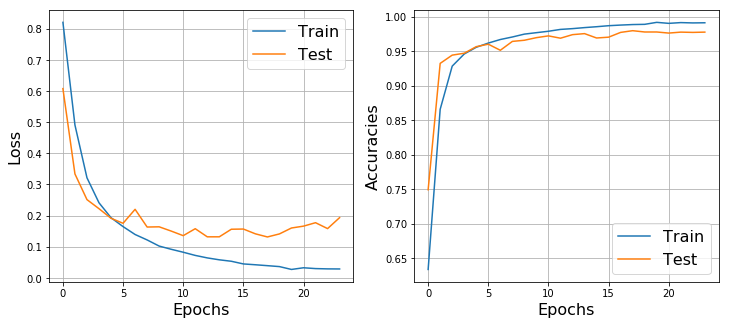

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


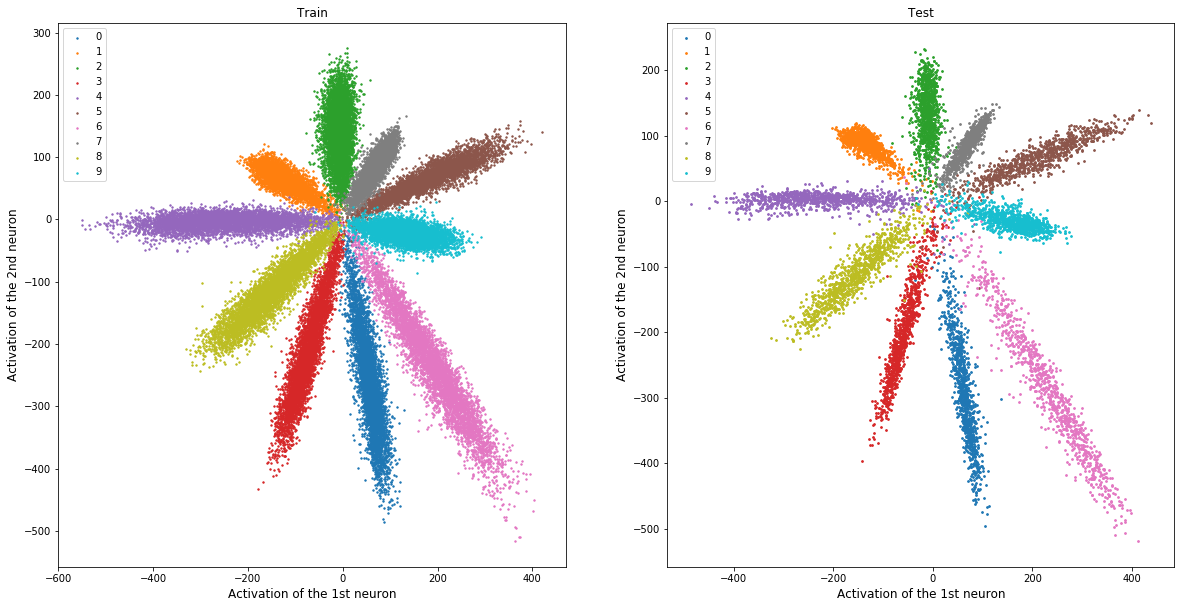

In [11]:
# Start train model and draw plots with lambda=0
accumulate_layer = None
train(model, epochs=25, _lambda=0)

# Get y marks for train and test
y_train = []
for (x, y) in train_loader:
    y_train.extend(y.data.numpy())

y_test = []
for (x, y) in test_loader:
    y_test.extend(y.data.numpy())
    
y_train = np.array(y_train)
y_test = np.array(y_test)

activation_plot(accumulate_layer, y_train, y_test)

Epoch 0... Train: 7/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0... Test: 1/79/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 24... (Train/Test) NLLLoss: 0.108/0.162...  Acc: 0.998/0.988

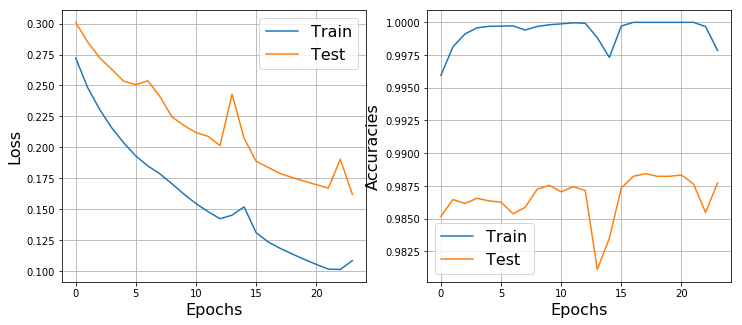

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


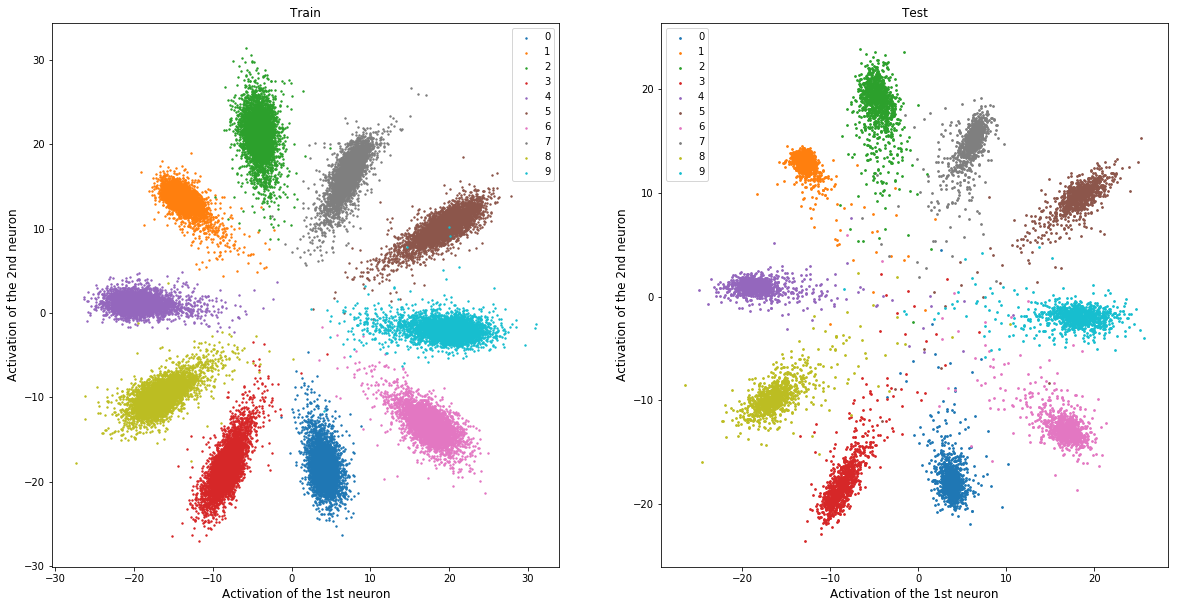

In [12]:
# Continue train model and draw plots with lambda = 0.1
accumulate_layer = None
train(model, epochs=25, _lambda=0.1)

# Get y marks for train and test
y_train = []
for (x, y) in train_loader:
    y_train.extend(y.data.numpy())

y_test = []
for (x, y) in test_loader:
    y_test.extend(y.data.numpy())
    
y_train = np.array(y_train)
y_test = np.array(y_test)

activation_plot(accumulate_layer, y_train, y_test)

Epoch 0... Train: 6/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0... Test: 8/79/469

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 14... (Train/Test) NLLLoss: 0.050/0.198...  Acc: 1.000/0.988

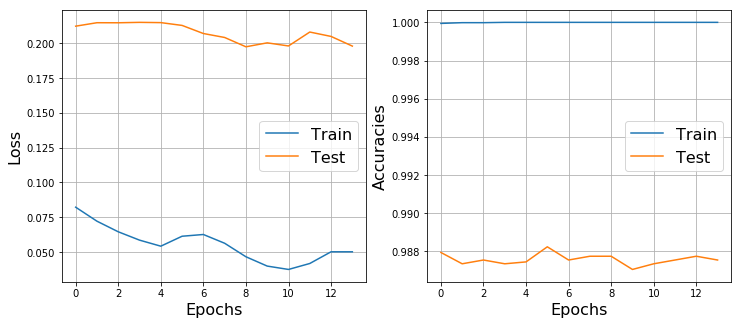

/home/anton.loskutov/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


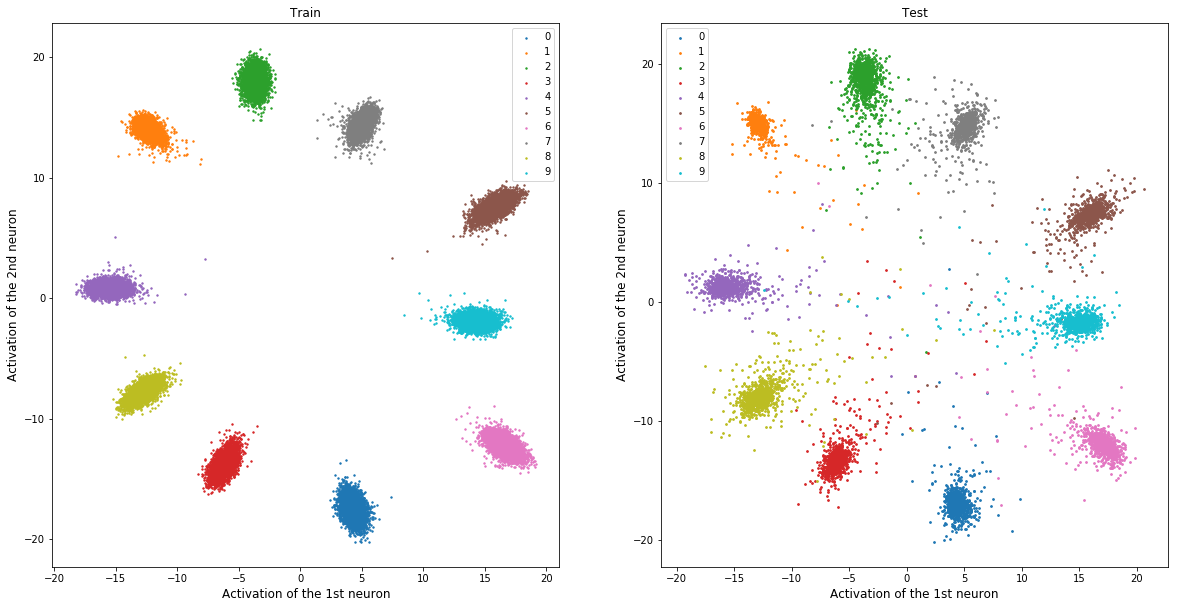

In [13]:
# Continue train model and draw plots with lambda=1
accumulate_layer = None
train(model, epochs=15, _lambda=1, center_optim=torch.optim.Adam)

# Get y marks for train and test
y_train = []
for (x, y) in train_loader:
    y_train.extend(y.data.numpy())

y_test = []
for (x, y) in test_loader:
    y_test.extend(y.data.numpy())
    
y_train = np.array(y_train)
y_test = np.array(y_test)

activation_plot(accumulate_layer, y_train, y_test)